In [ ]:
# Install necessary libraries
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn torch -q # Added torch for GPU check consistency

import xgboost as xgb
import pandas as pd
import numpy as np
import os
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Added StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay # Added ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import torch # To check for GPU availability

# Import the new models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB``


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
# Cell 2: Define Paths and Parameters (No changes needed)
import random
# --- Paths ---

CSV_PATH = 'combined_motionsense.csv' # Original full dataset

# --- Parameters ---
TRAIN_SIZE = 100000 # Number of samples for training set
TEST_SIZE = 20000  # Number of samples for evaluation set
TOTAL_SAMPLES = TRAIN_SIZE + TEST_SIZE
TARGET_POISON_RATE = 0.50 # Aim for balanced poisoned/clean overall before split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Data Columns ---
LABEL_COL = 'Label' # Original true label column name
REPORTED_LABEL_COL = 'reported_label' # Column we will create
POISON_FLAG_COL = 'is_poisoned' # Column we will create
ATTACK_TYPE_COL = 'attack_type' # Column we will create
ORIGINAL_LABEL_COL = 'original_label' # Column to store original label before poisoning
sensor_cols = [
    'attitude.roll','attitude.pitch','attitude.yaw',
    'gravity.x','gravity.y','gravity.z',
    'rotationRate.x','rotationRate.y','rotationRate.z',
    'userAcceleration.x','userAcceleration.y','userAcceleration.z'
]

print("Paths and parameters defined.")
print(f"Total samples to process: {TOTAL_SAMPLES}")

Paths and parameters defined.
Total samples to process: 120000


In [3]:
# Cell 3: Load Full Data and Define Poisoning Functions (No changes needed)

# --- Load Full Dataset ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Original dataset not found at {CSV_PATH}.")
try:
    # Load only necessary columns initially to save memory if dataset is very large
    cols_to_load = sensor_cols + [LABEL_COL]
    df_full = pd.read_csv(CSV_PATH, usecols=cols_to_load)
    print(f"Successfully loaded required columns from original dataset. Shape: {df_full.shape}")
except Exception as e:
    raise RuntimeError(f"Failed to load or read CSV file at {CSV_PATH}: {e}")

# Basic data validation
if LABEL_COL not in df_full.columns:
     raise ValueError(f"Label column '{LABEL_COL}' not found in the dataset.")
if not all(col in df_full.columns for col in sensor_cols):
    missing_sensors = [col for col in sensor_cols if col not in df_full.columns]
    raise ValueError(f"Missing sensor columns: {missing_sensors}")

# Get unique labels
activity_labels = sorted(list(df_full[LABEL_COL].unique()))
print(f"Unique activity labels found: {activity_labels}")

# Check if dataset is large enough
if len(df_full) < TOTAL_SAMPLES:
    raise ValueError(f"Dataset size ({len(df_full)}) is smaller than the required total samples ({TOTAL_SAMPLES}). Consider reducing TRAIN_SIZE/TEST_SIZE.")


# --- Poisoning Functions ---
similar_pairs = {
    'WALKING': 'JOGGING', 'JOGGING': 'WALKING',
    'SITTING': 'STANDING', 'STANDING': 'SITTING',
    'UPSTAIRS': 'DOWNSTAIRS', 'DOWNSTAIRS': 'UPSTAIRS',
}

def poison_similarity(original_label, similar_pairs_map):
    return similar_pairs_map.get(original_label, original_label)

def poison_difference(original_label, all_labels):
    possible_labels = [l for l in all_labels if l != original_label]
    return random.choice(possible_labels) if possible_labels else original_label

def get_poisoned_label(original_label, attack_type, all_labels, similar_pairs_map):
    if attack_type == 'similarity':
        return poison_similarity(original_label, similar_pairs_map)
    elif attack_type == 'difference':
        return poison_difference(original_label, all_labels)
    else: # clean
        return original_label

print("Poisoning functions defined.")

Successfully loaded required columns from original dataset. Shape: (1412865, 13)
Unique activity labels found: ['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']
Poisoning functions defined.


In [6]:
# Cell 4: Sample Data and Apply Poisoning (No changes needed)

print(f"Sampling {TOTAL_SAMPLES} rows from the full dataset...")
# Ensure reproducibility if df_full index is not standard range
if len(df_full) > TOTAL_SAMPLES:
    sampled_indices = np.random.choice(df_full.index, TOTAL_SAMPLES, replace=False)
    df_sampled = df_full.loc[sampled_indices].copy()
else:
    print("Warning: Requested sample size equals or exceeds dataset size. Using the entire dataset.")
    df_sampled = df_full.copy()
    TOTAL_SAMPLES = len(df_full) # Adjust total samples if needed
    TRAIN_SIZE = int(TOTAL_SAMPLES * (1 - TEST_SIZE / (TRAIN_SIZE + TEST_SIZE))) # Adjust train size proportionally
    TEST_SIZE = TOTAL_SAMPLES - TRAIN_SIZE


df_sampled.reset_index(drop=True, inplace=True)

print(f"Applying poisoning logic to {TOTAL_SAMPLES} samples (target rate: {TARGET_POISON_RATE*100:.0f}%)...")

# Determine target number of poisoned samples
num_poisoned_total_target = int(TOTAL_SAMPLES * TARGET_POISON_RATE)

# Randomly select indices to poison
poison_indices = np.random.choice(df_sampled.index, num_poisoned_total_target, replace=False)

# Initialize new columns
df_sampled[ORIGINAL_LABEL_COL] = df_sampled[LABEL_COL] # Store original label
df_sampled[POISON_FLAG_COL] = False
df_sampled[REPORTED_LABEL_COL] = df_sampled[ORIGINAL_LABEL_COL]
df_sampled[ATTACK_TYPE_COL] = 'clean'

# Apply poisoning
poisoned_count = 0
for i, idx in enumerate(poison_indices):
    original = df_sampled.loc[idx, ORIGINAL_LABEL_COL]
    # Ensure attack type assignment handles cases where num_poisoned_total_target is odd
    attack = 'similarity' if random.random() < 0.5 else 'difference' # Randomly assign attack type for balance
    poisoned_lbl = get_poisoned_label(original, attack, activity_labels, similar_pairs)

    if poisoned_lbl != original:
        df_sampled.loc[idx, REPORTED_LABEL_COL] = poisoned_lbl
        df_sampled.loc[idx, POISON_FLAG_COL] = True
        df_sampled.loc[idx, ATTACK_TYPE_COL] = attack
        poisoned_count += 1

actual_poison_rate = poisoned_count / TOTAL_SAMPLES
print(f"Applied poisoning to {poisoned_count} samples ({actual_poison_rate*100:.1f}% of total sampled).")
print("Value counts for poisoning flag:")
print(df_sampled[POISON_FLAG_COL].value_counts(normalize=True))
print("\nValue counts for attack type (among poisoned):")
print(df_sampled[df_sampled[POISON_FLAG_COL] == True][ATTACK_TYPE_COL].value_counts(normalize=True))

Sampling 120000 rows from the full dataset...
Applying poisoning logic to 120000 samples (target rate: 50%)...
Applied poisoning to 30048 samples (25.0% of total sampled).
Value counts for poisoning flag:
is_poisoned
False    0.7496
True     0.2504
Name: proportion, dtype: float64

Value counts for attack type (among poisoned):
attack_type
difference    1.0
Name: proportion, dtype: float64


Splitting data into Train (100000) and Test (20000) sets...
Stratifying by both poison flag and original label.
Training set shape: (100000, 17)
Test set shape: (20000, 17)
Poisoning rate in Training set: 0.250
Poisoning rate in Test set: 0.250


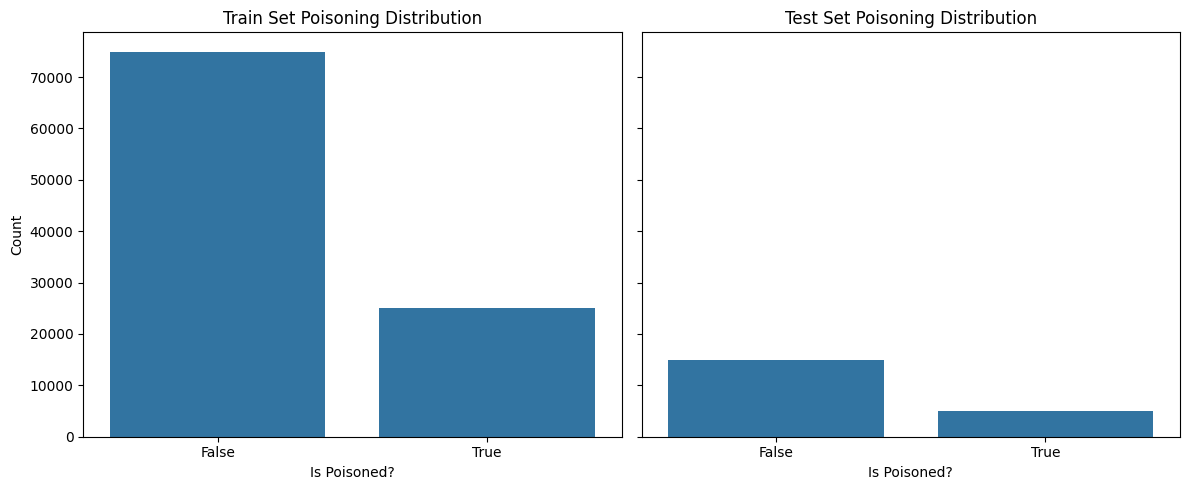

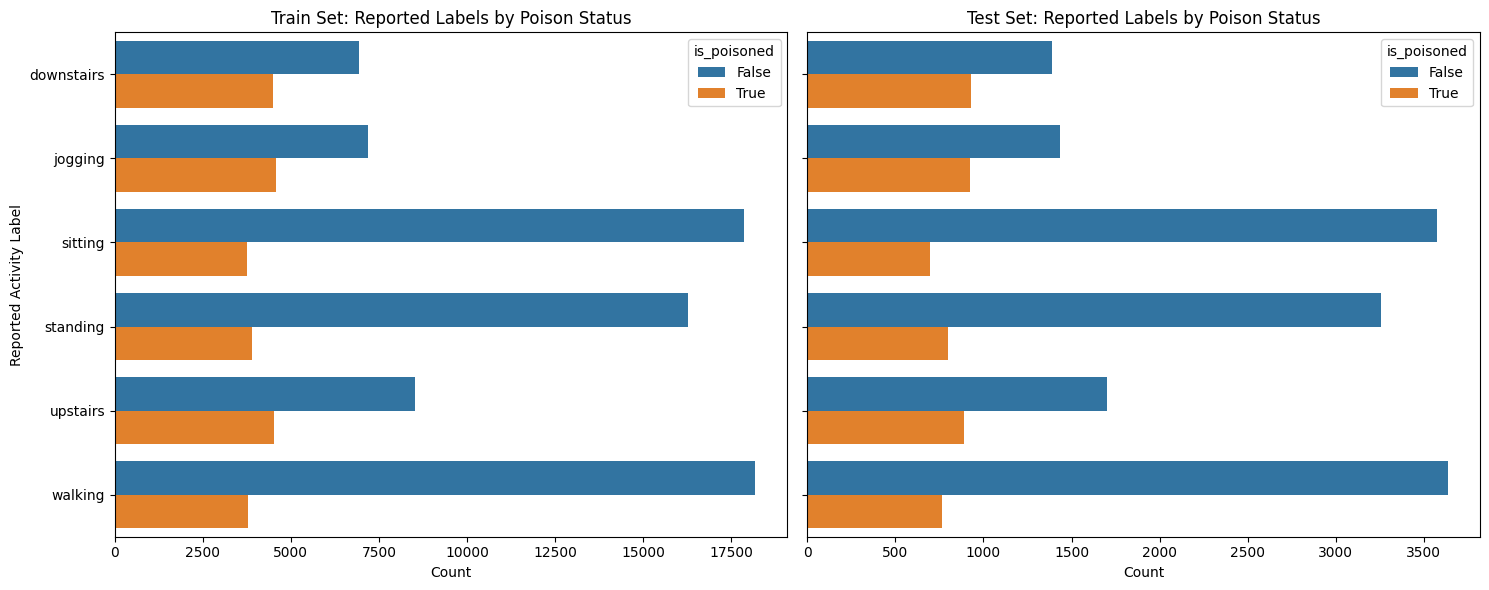

In [9]:
# Cell 5: Perform Single Train/Test Split (No changes needed)

print(f"Splitting data into Train ({TRAIN_SIZE}) and Test ({TEST_SIZE}) sets...")

# Calculate test_size fraction based on potentially adjusted TOTAL_SAMPLES
if TOTAL_SAMPLES > 0:
    test_fraction = TEST_SIZE / TOTAL_SAMPLES
else:
    raise ValueError("TOTAL_SAMPLES is zero, cannot perform split.")


# Split the entire dataframe to keep all columns aligned
# Stratify by the poison flag AND the original label if possible for better representation
# Check if stratification is possible
min_samples_per_group = df_sampled.groupby([POISON_FLAG_COL, ORIGINAL_LABEL_COL]).size().min()
n_splits_required = 2 # For train/test split

if min_samples_per_group >= n_splits_required:
    print("Stratifying by both poison flag and original label.")
    stratify_cols = df_sampled[[POISON_FLAG_COL, ORIGINAL_LABEL_COL]]
else:
    print(f"Warning: Cannot stratify by both poison flag and original label (minimum group size {min_samples_per_group} < {n_splits_required}). Stratifying by poison flag only.")
    stratify_cols = df_sampled[POISON_FLAG_COL]


train_df, test_df = train_test_split(
    df_sampled,
    test_size=test_fraction,
    random_state=SEED,
    stratify=stratify_cols
)

# Ensure the sizes match the target as closely as possible after stratification
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Verify poisoning rate in each set
print(f"Poisoning rate in Training set: {train_df[POISON_FLAG_COL].mean():.3f}")
print(f"Poisoning rate in Test set: {test_df[POISON_FLAG_COL].mean():.3f}")

# --- Add Visualization: Distribution of Labels/Poisoning in Train/Test ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.countplot(data=train_df, x=POISON_FLAG_COL, ax=axes[0]).set_title('Train Set Poisoning Distribution')
sns.countplot(data=test_df, x=POISON_FLAG_COL, ax=axes[1]).set_title('Test Set Poisoning Distribution')
axes[0].set_xlabel("Is Poisoned?")
axes[1].set_xlabel("Is Poisoned?")
axes[0].set_ylabel("Count")
axes[1].set_ylabel("")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.countplot(data=train_df, y=REPORTED_LABEL_COL, hue=POISON_FLAG_COL, ax=axes[0], order=activity_labels).set_title('Train Set: Reported Labels by Poison Status')
sns.countplot(data=test_df, y=REPORTED_LABEL_COL, hue=POISON_FLAG_COL, ax=axes[1], order=activity_labels).set_title('Test Set: Reported Labels by Poison Status')
axes[0].set_xlabel("Count")
axes[1].set_xlabel("Count")
axes[0].set_ylabel("Reported Activity Label")
axes[1].set_ylabel("")
plt.tight_layout()
plt.show()

In [10]:
# Cell 6: Preprocess Data for Detection Model (Add StandardScaler)

print("Preprocessing data for DETECTION model...")

# Define features (X) and target (y) for detection
y_detect_train = train_df[POISON_FLAG_COL].astype(int)
y_detect_test = test_df[POISON_FLAG_COL].astype(int)

# Features: sensor columns (numerical) + reported_label (categorical)
detection_features = sensor_cols + [REPORTED_LABEL_COL]
X_detect_train_raw = train_df[detection_features]
X_detect_test_raw = test_df[detection_features]

# Create a preprocessor using ColumnTransformer
# Scale numerical features, OneHotEncode categorical features
preprocessor_detect = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), sensor_cols), # Scale numerical sensor columns
        ('cat', OneHotEncoder(categories=[activity_labels], handle_unknown='ignore', sparse_output=False), [REPORTED_LABEL_COL]) # OHE categorical
    ],
    remainder='drop' # Drop any columns not specified
)

# Fit the preprocessor on the training data and transform both sets
X_detect_train = preprocessor_detect.fit_transform(X_detect_train_raw)
X_detect_test = preprocessor_detect.transform(X_detect_test_raw)

# Get feature names after transformation
try:
    feature_names_detect = preprocessor_detect.get_feature_names_out()
    print(f"Detection Training Features shape: {X_detect_train.shape}")
    print(f"Detection Test Features shape: {X_detect_test.shape}")
    # print("Detection Feature Names:", feature_names_detect) # Optional
except Exception as e:
    print(f"Could not get feature names: {e}")
    feature_names_detect = None # Fallback


print("Preprocessing for detection complete.")

Preprocessing data for DETECTION model...
Detection Training Features shape: (100000, 18)
Detection Test Features shape: (20000, 18)
Preprocessing for detection complete.


In [12]:
# Cell 7 & 8 Combined: Train and Evaluate MULTIPLE Detection Models

print("\\n" + "="*60)
print("--- Training and Evaluating MULTIPLE Detection Models ---")
print("="*60)

# Check for GPU for XGBoost
use_gpu = torch.cuda.is_available()
tree_method = 'gpu_hist' if use_gpu else 'hist'
device_type = "GPU" if use_gpu else "CPU"
print(f"Device detected for XGBoost: {device_type}")

# --- Define Models ---
models_to_train = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'), # Increased max_iter
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=SEED, n_jobs=-1, max_depth=10, min_samples_leaf=5), # Added reasonable defaults
    "SVM": SVC(probability=True, random_state=SEED, C=1.0, kernel='rbf'), # Enable probability for potential later use, RBF kernel often good
    "KNN": KNeighborsClassifier(n_neighbors=7, n_jobs=-1), # K=7 is a common choice
    "GaussianNB": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(
                    objective='binary:logistic',
                    eval_metric='logloss',
                    use_label_encoder=False,
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=SEED,
                    tree_method=tree_method
                )
}

# --- Store Results ---
trained_models = {}
results = {}

# --- Train and Evaluate Each Model ---
max_training_time = 40 * 60 # 20 minutes limit per model

for name, model in models_to_train.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()

    try:
        # Handle potential exceptions during training (e.g., convergence issues)
        model.fit(X_detect_train, y_detect_train)
        end_time = time.time()
        training_time = end_time - start_time
        trained_models[name] = model # Store the trained model

        print(f"Training finished in {training_time:.2f} seconds.")
        if training_time > max_training_time:
             print(f"WARNING: Training time exceeded the {max_training_time/60:.0f}-minute limit!")
        else:
             print(f"Training completed within the {max_training_time/60:.0f}-minute time limit.")


        # --- Evaluate ---
        print(f"Evaluating {name} on the test set...")
        y_pred_test = model.predict(X_detect_test)
        # y_prob_test = model.predict_proba(X_detect_test)[:, 1] # Optional: get probabilities

        # Store predictions IF this model is selected for downstream tasks (using XGBoost here)
        if name == "XGBoost":
            test_df['detected_poisoned'] = y_pred_test
            print("Stored XGBoost predictions in 'detected_poisoned' column for downstream use.")


        # Calculate Metrics
        accuracy = accuracy_score(y_detect_test, y_pred_test)
        recall = recall_score(y_detect_test, y_pred_test, zero_division=0) # Recall for the positive class (poisoned=1)
        f1 = f1_score(y_detect_test, y_pred_test, zero_division=0) # F1 for the positive class
        f1_weighted = f1_score(y_detect_test, y_pred_test, average='weighted', zero_division=0)
        cm = confusion_matrix(y_detect_test, y_pred_test)
        cr = classification_report(y_detect_test, y_pred_test, target_names=['Not Poisoned (0)', 'Poisoned (1)'], zero_division=0, output_dict=True) # Get dict for easier parsing

        # Store results
        results[name] = {
            'Training Time (s)': training_time,
            'Accuracy': accuracy,
            'Recall (Poisoned)': recall,
            'F1 (Poisoned)': f1,
            'F1 (Weighted)': f1_weighted,
            'Confusion Matrix': cm,
            'Classification Report': cr,
            'Predictions': y_pred_test # Store predictions for potential comparison
        }

        print(f"Evaluation Metrics for {name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Recall (Poisoned): {recall:.4f}")
        print(f"  F1 Score (Poisoned): {f1:.4f}")
        print(f"  F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"  Confusion Matrix:\n{cm}")

    except Exception as e:
        print(f"ERROR: Failed to train or evaluate {name}: {e}")
        results[name] = { # Store error indication
            'Training Time (s)': -1, 'Accuracy': -1, 'Recall (Poisoned)': -1,
            'F1 (Poisoned)': -1, 'F1 (Weighted)': -1, 'Confusion Matrix': None,
            'Classification Report': None, 'Predictions': None, 'Error': str(e)
        }


# --- Consolidate Results ---
results_df = pd.DataFrame.from_dict(results, orient='index')

# Add 'Error' column if missing (for backward compatibility)
if 'Error' not in results_df.columns:
    results_df['Error'] = None

# Select key metrics for display
results_summary = results_df[['Training Time (s)', 'Accuracy', 'Recall (Poisoned)', 'F1 (Poisoned)', 'F1 (Weighted)', 'Error']].sort_values(by='F1 (Poisoned)', ascending=False)

print("\n\n" + "="*60)
print("--- Detection Model Performance Summary ---")
print("="*60)
print(results_summary)
print("\nNote: Recall and F1 scores shown are for the 'Poisoned (1)' class.")

\n============================================================
--- Training and Evaluating MULTIPLE Detection Models ---
Device detected for XGBoost: CPU

--- Training Logistic Regression ---
Training finished in 0.26 seconds.
Training completed within the 40-minute time limit.
Evaluating Logistic Regression on the test set...
Evaluation Metrics for Logistic Regression:
  Accuracy: 0.7488
  Recall (Poisoned): 0.0026
  F1 Score (Poisoned): 0.0051
  F1 Score (Weighted): 0.6431
  Confusion Matrix:
[[14962    30]
 [ 4995    13]]

--- Training Random Forest ---
Training finished in 4.97 seconds.
Training completed within the 40-minute time limit.
Evaluating Random Forest on the test set...
Evaluation Metrics for Random Forest:
  Accuracy: 0.9174
  Recall (Poisoned): 0.6801
  F1 Score (Poisoned): 0.8049
  F1 Score (Weighted): 0.9119
  Confusion Matrix:
[[14943    49]
 [ 1602  3406]]

--- Training SVM ---
Training finished in 6068.14 seconds.
Evaluating SVM on the test set...
Evaluation Metri

c:\Users\Hussien\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:37:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training finished in 0.56 seconds.
Training completed within the 40-minute time limit.
Evaluating XGBoost on the test set...
Stored XGBoost predictions in 'detected_poisoned' column for downstream use.
Evaluation Metrics for XGBoost:
  Accuracy: 0.9301
  Recall (Poisoned): 0.7702
  F1 Score (Poisoned): 0.8465
  F1 Score (Weighted): 0.9276
  Confusion Matrix:
[[14744   248]
 [ 1151  3857]]


--- Detection Model Performance Summary ---
                     Training Time (s)  Accuracy  Recall (Poisoned)  \
XGBoost                       0.560768   0.93005           0.770168   
Random Forest                 4.966654   0.91745           0.680112   
KNN                           0.006605   0.91015           0.709864   
SVM                        6068.137391   0.90145           0.643171   
GaussianNB                    0.029016   0.66190           0.545927   
Logistic Regression           0.259464   0.74875           0.002596   

                     F1 (Poisoned)  F1 (Weighted) Error  
XGBoos



--- Detection Model Performance Visualizations ---


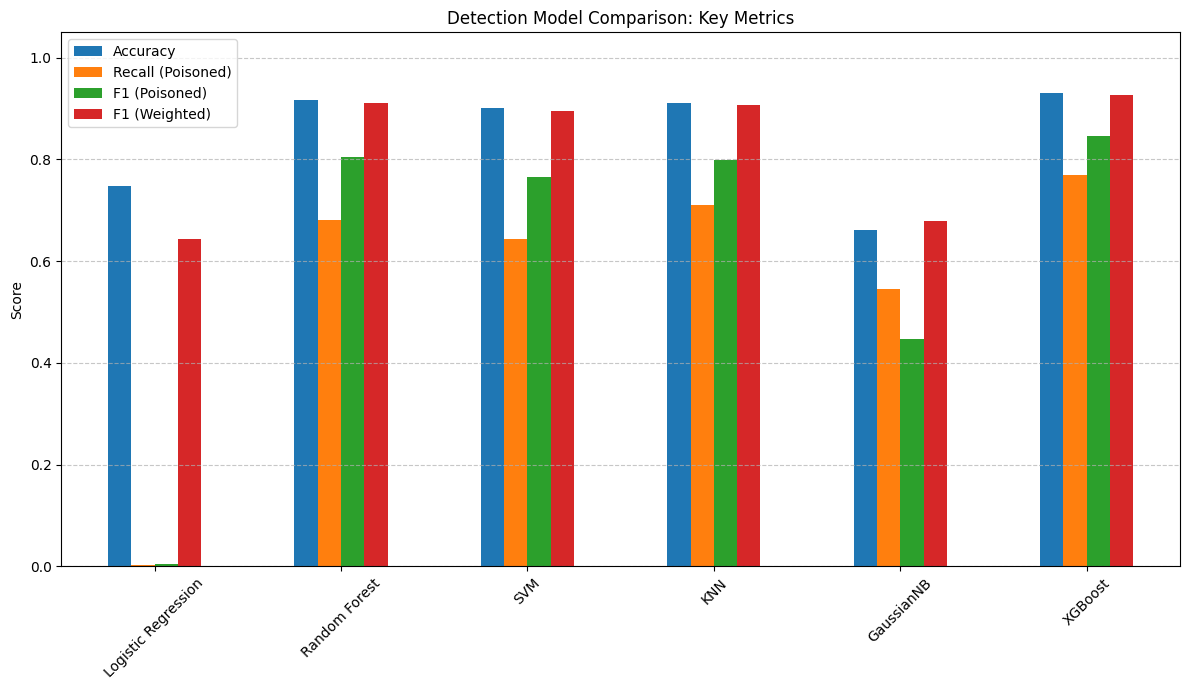

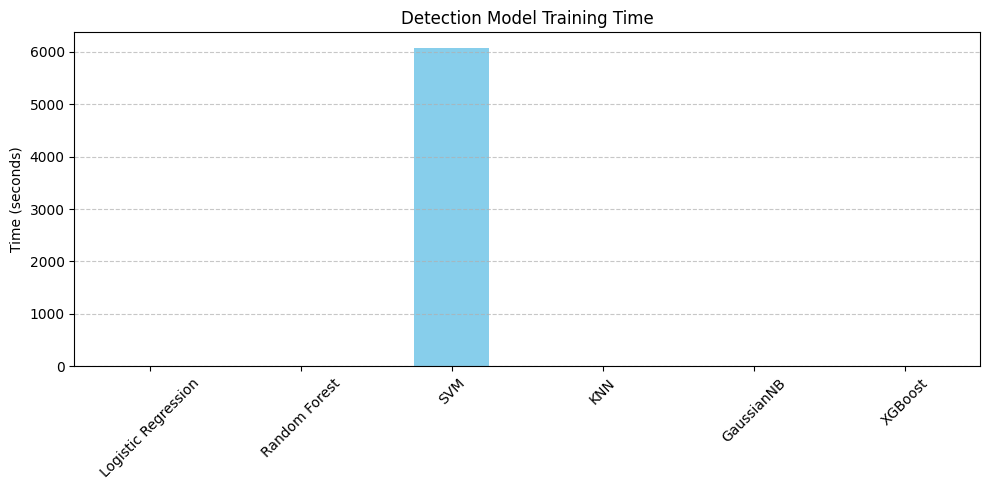

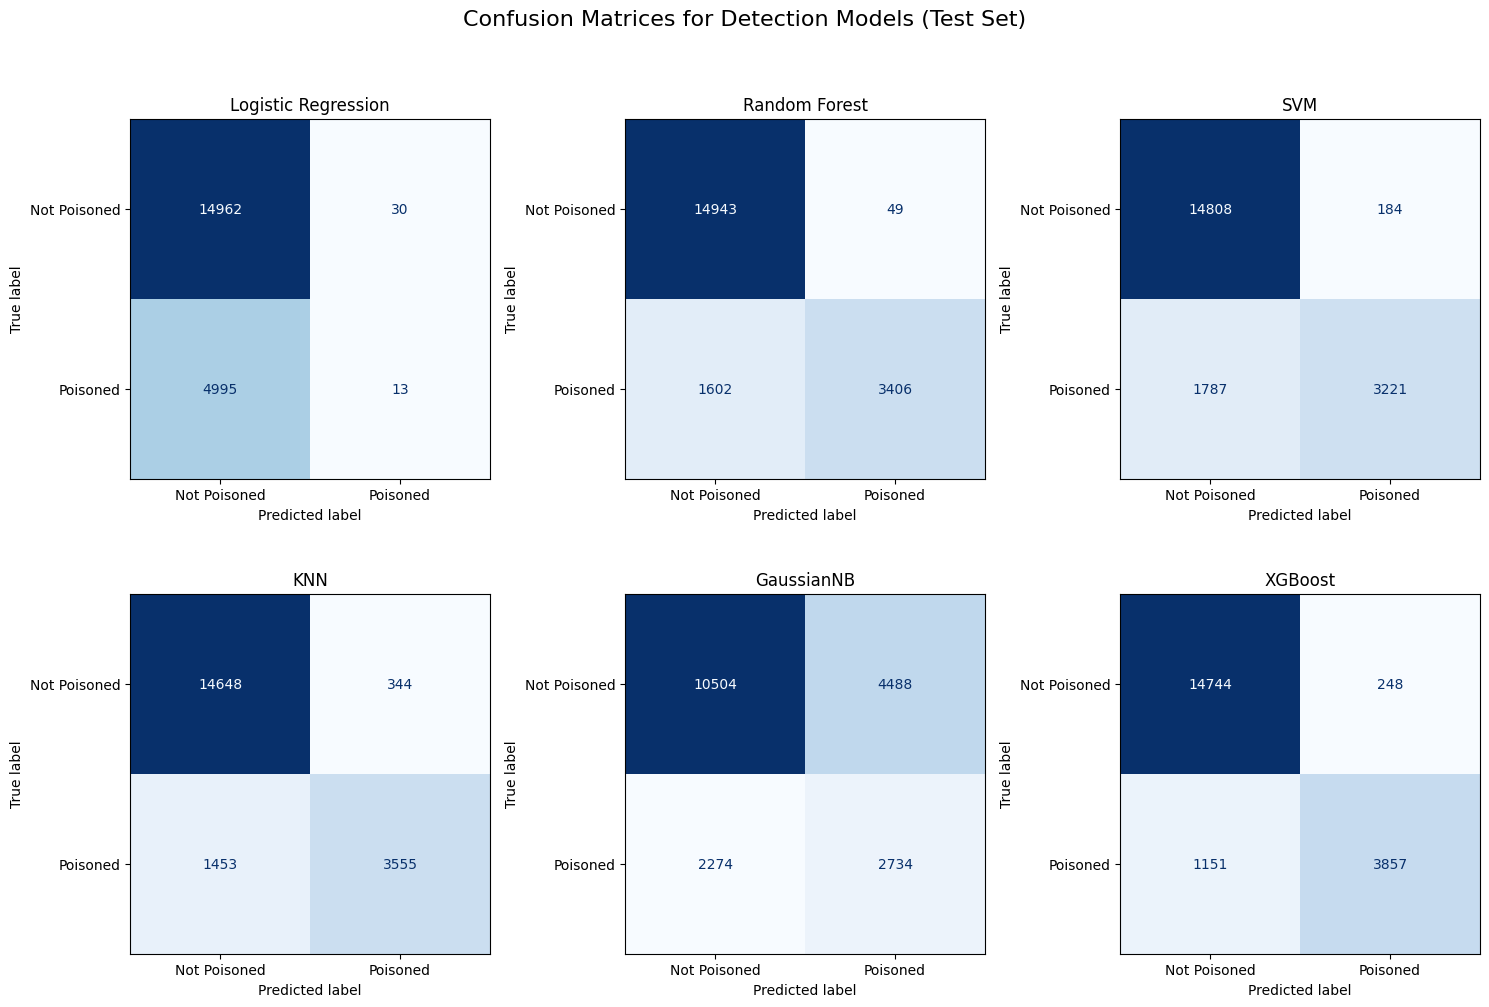


--- Feature Importance (Example) ---


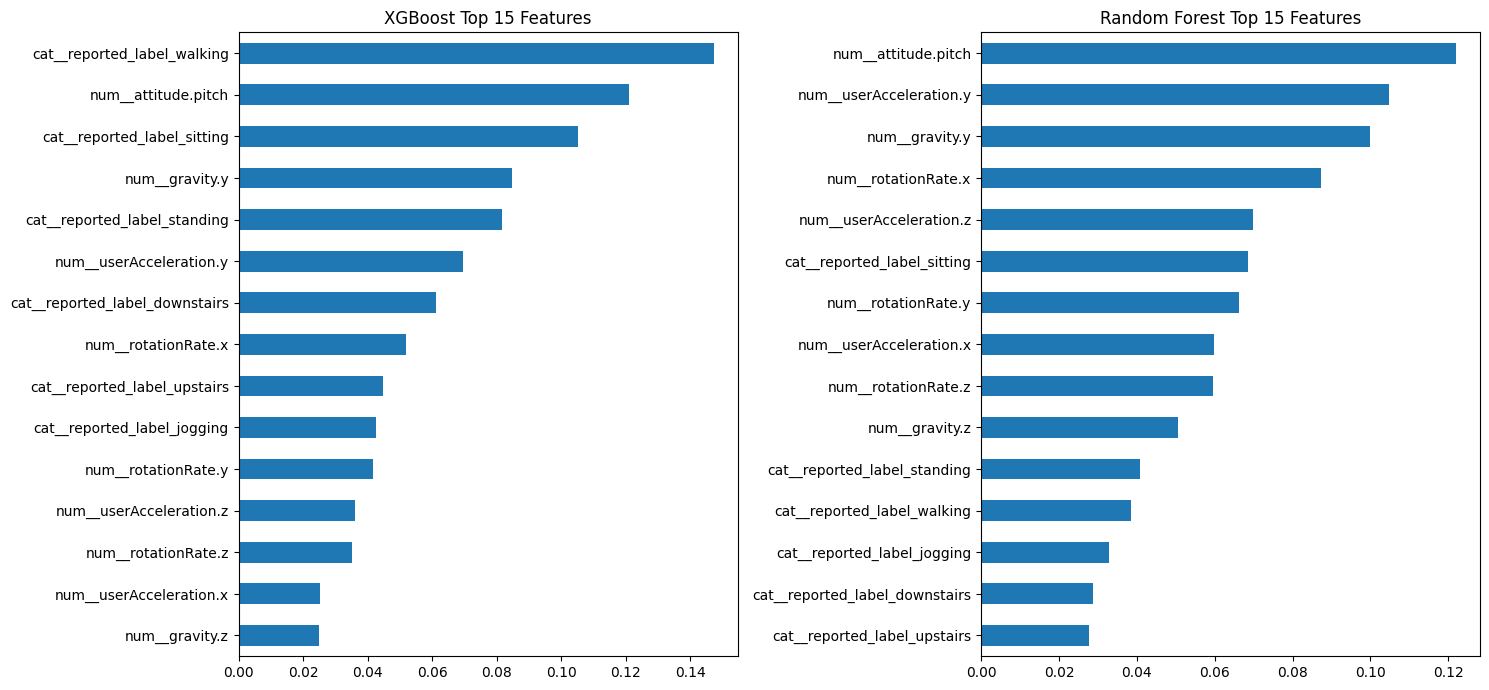

In [13]:
# Cell 8b: Visualizations for Detection Model Comparison

print("\n\n" + "="*60)
print("--- Detection Model Performance Visualizations ---")
print("="*60)

# Filter out models that failed
valid_results_df = results_df[results_df['Training Time (s)'] >= 0].copy()

if valid_results_df.empty:
    print("No models trained successfully, skipping visualizations.")
else:
    # --- Bar Chart: Key Metrics ---
    metrics_to_plot = ['Accuracy', 'Recall (Poisoned)', 'F1 (Poisoned)', 'F1 (Weighted)']
    valid_results_df[metrics_to_plot].plot(kind='bar', figsize=(12, 7), rot=45)
    plt.title('Detection Model Comparison: Key Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1.05) # Scores are between 0 and 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Bar Chart: Training Time ---
    valid_results_df['Training Time (s)'].plot(kind='bar', figsize=(10, 5), rot=45, color='skyblue')
    plt.title('Detection Model Training Time')
    plt.ylabel('Time (seconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Confusion Matrices ---
    num_models = len(valid_results_df)
    if num_models > 0:
        cols = 3
        rows = (num_models + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten() # Flatten to 1D array for easy iteration

        for i, (name, data) in enumerate(valid_results_df.iterrows()):
            cm = data['Confusion Matrix']
            if cm is not None:
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Poisoned', 'Poisoned'])
                disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
                axes[i].set_title(f"{name}")
            else:
                axes[i].text(0.5, 0.5, 'CM\nNot Available', horizontalalignment='center', verticalalignment='center', fontsize=12)
                axes[i].set_title(f"{name}")
                axes[i].axis('off') # Hide axes if CM is missing

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle('Confusion Matrices for Detection Models (Test Set)', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

    # --- Feature Importance (Example for XGBoost and Random Forest) ---
    print("\n--- Feature Importance (Example) ---")
    feat_import_models = {"XGBoost": None, "Random Forest": None}

    # Get feature names if available
    if feature_names_detect is None:
         print("Warning: Cannot show feature importance because feature names are not available.")
    else:
        for name in feat_import_models:
            if name in trained_models:
                model = trained_models[name]
                if hasattr(model, 'feature_importances_'):
                    feat_import_models[name] = pd.Series(model.feature_importances_, index=feature_names_detect).sort_values(ascending=False)
                else:
                    print(f"Feature importance not directly available for {name} with current settings.")
            else:
                 print(f"{name} model not found in trained models.")


        # Plotting (Top N features)
        top_n = 15
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))
        axes = axes.flatten()
        plotted_count = 0

        if feat_import_models["XGBoost"] is not None:
            feat_import_models["XGBoost"].head(top_n).plot(kind='barh', ax=axes[plotted_count], title=f'XGBoost Top {top_n} Features')
            axes[plotted_count].invert_yaxis()
            plotted_count += 1

        if feat_import_models["Random Forest"] is not None:
             feat_import_models["Random Forest"].head(top_n).plot(kind='barh', ax=axes[plotted_count], title=f'Random Forest Top {top_n} Features')
             axes[plotted_count].invert_yaxis()
             plotted_count += 1

        # Remove empty plots if only one model had importance
        if plotted_count < 2:
            fig.delaxes(axes[1])
            fig.set_size_inches(8, 7) # Adjust size

        if plotted_count > 0:
            plt.tight_layout()
            plt.show()
        else:
            print("No feature importance plots generated.")

In [18]:
# Cell 9: Preprocess Data for Sanitization Model (Add Scaler)

print("Preprocessing data for SANITIZATION model...")

# Target: Original activity label (needs label encoding)
label_encoder_sani = LabelEncoder()
y_sani_train = label_encoder_sani.fit_transform(train_df[ORIGINAL_LABEL_COL])
y_sani_test = label_encoder_sani.transform(test_df[ORIGINAL_LABEL_COL])

label_mapping = dict(zip(label_encoder_sani.classes_, label_encoder_sani.transform(label_encoder_sani.classes_)))
print("Label Encoding Mapping for Sanitization Target:", label_mapping)
num_classes = len(label_mapping)
print(f"Number of classes for sanitization: {num_classes}")

# Features: Sensor columns ONLY
# Models like LR, SVM, KNN benefit from scaling, so we apply StandardScaler
sani_scaler = StandardScaler()
X_sani_train_raw = train_df[sensor_cols].values # Get numpy array first
X_sani_test_raw = test_df[sensor_cols].values

print("Applying StandardScaler to sensor features for sanitization...")
X_sani_train = sani_scaler.fit_transform(X_sani_train_raw)
X_sani_test = sani_scaler.transform(X_sani_test_raw) # Use transform only on test data

print(f"Sanitization Training Features shape (scaled): {X_sani_train.shape}")
print(f"Sanitization Test Features shape (scaled): {X_sani_test.shape}")
print(f"Sanitization Training Target shape: {y_sani_train.shape}")
print(f"Sanitization Test Target shape: {y_sani_test.shape}")
print("Preprocessing for sanitization complete.")

Preprocessing data for SANITIZATION model...
Label Encoding Mapping for Sanitization Target: {'downstairs': np.int64(0), 'jogging': np.int64(1), 'sitting': np.int64(2), 'standing': np.int64(3), 'upstairs': np.int64(4), 'walking': np.int64(5)}
Number of classes for sanitization: 6
Applying StandardScaler to sensor features for sanitization...
Sanitization Training Features shape (scaled): (100000, 12)
Sanitization Test Features shape (scaled): (20000, 12)
Sanitization Training Target shape: (100000,)
Sanitization Test Target shape: (20000,)
Preprocessing for sanitization complete.


\n============================================================
--- Training and Evaluating MULTIPLE Sanitization Models ---
Target variable for sanitization: Encoded original labels (shape (100000,))
Features for sanitization: Scaled sensor data (shape (100000, 12))

--- Training Sanitizer: Logistic Regression ---


c:\Users\Hussien\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training finished in 4.46 seconds.
Training completed within the 20-minute time limit.
Evaluating Sanitizer Logistic Regression on the test set...
Direct Evaluation Metrics for Sanitizer Logistic Regression:
  Accuracy: 0.5422
  F1 Score (Weighted): 0.4632
  F1 Score (Macro): 0.3385

--- Training Sanitizer: Random Forest ---
Training finished in 7.60 seconds.
Training completed within the 20-minute time limit.
Evaluating Sanitizer Random Forest on the test set...
Direct Evaluation Metrics for Sanitizer Random Forest:
  Accuracy: 0.8153
  F1 Score (Weighted): 0.7988
  F1 Score (Macro): 0.7308

--- Training Sanitizer: SVM ---
Training finished in 89.42 seconds.
Training completed within the 20-minute time limit.
Evaluating Sanitizer SVM on the test set...
Direct Evaluation Metrics for Sanitizer SVM:
  Accuracy: 0.8407
  F1 Score (Weighted): 0.8322
  F1 Score (Macro): 0.7770

--- Training Sanitizer: KNN ---
Training finished in 0.16 seconds.
Training completed within the 20-minute time li

c:\Users\Hussien\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:51:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training finished in 4.65 seconds.
Training completed within the 20-minute time limit.
Evaluating Sanitizer XGBoost on the test set...
Direct Evaluation Metrics for Sanitizer XGBoost:
  Accuracy: 0.8746
  F1 Score (Weighted): 0.8718
  F1 Score (Macro): 0.8286


--- Sanitizer Model Performance Summary (Direct Evaluation) ---
                     Training Time (s)  Accuracy  F1 (Weighted)  F1 (Macro)
KNN                           0.160397   0.88100       0.877296    0.834660
XGBoost                       4.653034   0.87460       0.871843    0.828623
SVM                          89.422483   0.84075       0.832203    0.776958
Random Forest                 7.598160   0.81525       0.798807    0.730762
GaussianNB                    0.020680   0.72640       0.709034    0.614247
Logistic Regression           4.461311   0.54215       0.463215    0.338529

Note: Evaluated based on predicting the true original label from sensor data.


--- Sanitizer Model Performance Visualizations ---


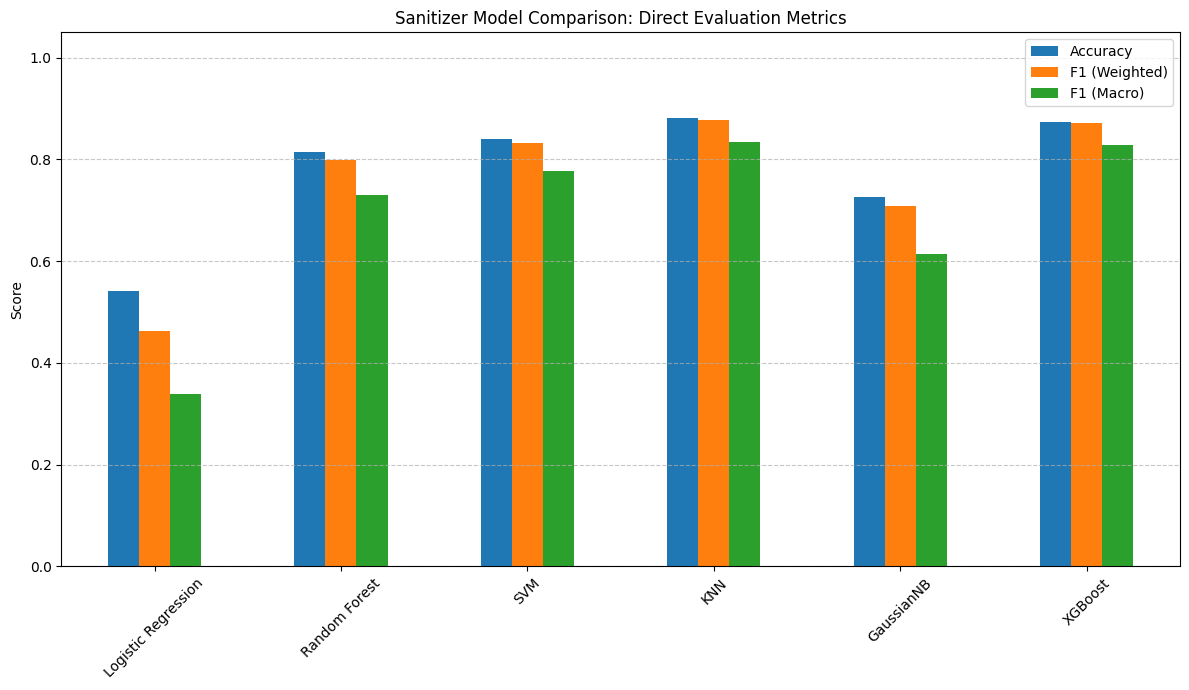

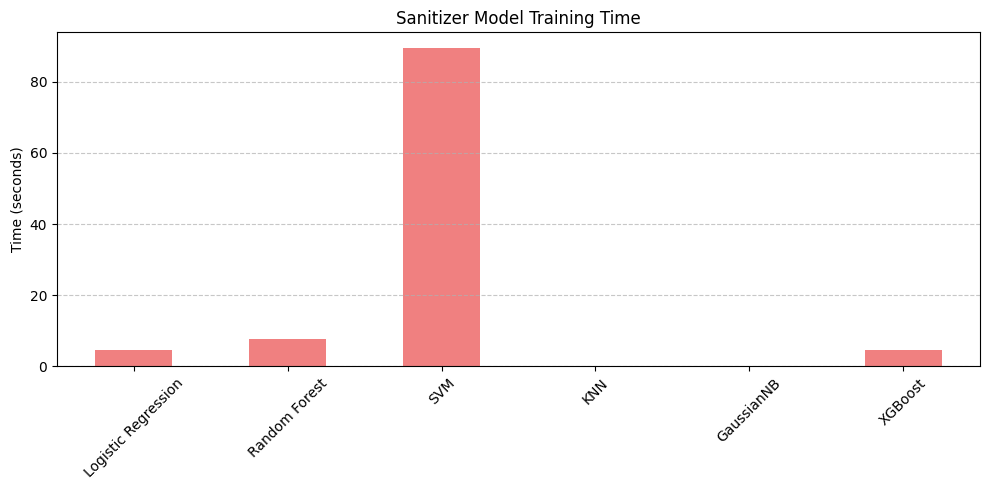


Confusion Matrix for Best Sanitizer (KNN):


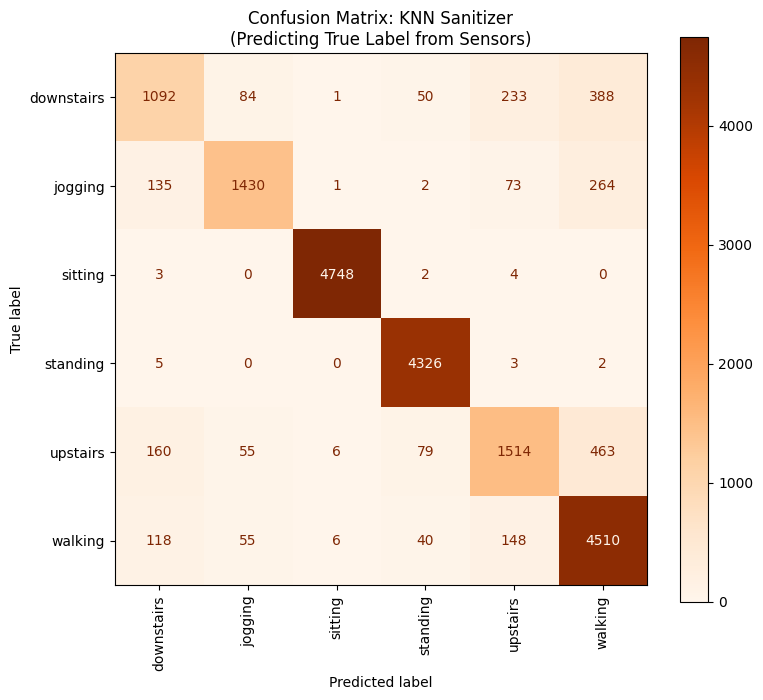

In [20]:
# Cell 10 & 10b: Train and Evaluate MULTIPLE Sanitization Models + Visualizations

print("\\n" + "="*60)
print("--- Training and Evaluating MULTIPLE Sanitization Models ---")
print("="*60)

# Reuse GPU check from detection phase
# use_gpu = torch.cuda.is_available() # Assumes this was run before
# tree_method = 'gpu_hist' if use_gpu else 'hist'
# device_type = "GPU" if use_gpu else "CPU"
# print(f"Device potentially used by XGBoost: {device_type}") # Already printed earlier

# --- Define Models for Multi-Class Sanitization ---
# Note: Adjust hyperparameters for multi-class task. SVM can be slow.
sanitizer_models_to_train = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000, solver='saga', multi_class='multinomial', n_jobs=-1), # Multinomial, saga solver often good for multiclass
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1, max_depth=12, min_samples_leaf=3), # Deeper trees potentially needed
    "SVM": SVC(random_state=SEED, C=1.0, kernel='rbf', decision_function_shape='ovr'), # OVR is often faster than OVO for many classes
    "KNN": KNeighborsClassifier(n_neighbors=7, n_jobs=-1), # K=7 is a common choice
    "GaussianNB": GaussianNB(), # Assumes features are Gaussian after scaling
    "XGBoost": xgb.XGBClassifier(
                    objective='multi:softmax', # Changed from softprob if direct prediction is needed
                    num_class=num_classes,
                    eval_metric='mlogloss',
                    use_label_encoder=False,
                    n_estimators=250,
                    learning_rate=0.1,
                    max_depth=7,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=SEED,
                    tree_method=tree_method # Use tree_method defined earlier
                )
}

# --- Store Results ---
trained_sanitizers = {}
sanitizer_results = {}

# --- Train and Evaluate Each Sanitizer Model ---
max_training_time_sani = 20 * 60 # 20 minutes limit per model

print(f"Target variable for sanitization: Encoded original labels (shape {y_sani_train.shape})")
print(f"Features for sanitization: Scaled sensor data (shape {X_sani_train.shape})")


for name, model in sanitizer_models_to_train.items():
    print(f"\n--- Training Sanitizer: {name} ---")
    start_time = time.time()

    try:
        model.fit(X_sani_train, y_sani_train)
        end_time = time.time()
        training_time = end_time - start_time
        trained_sanitizers[name] = model # Store the trained sanitizer

        print(f"Training finished in {training_time:.2f} seconds.")
        if training_time > max_training_time_sani:
             print(f"WARNING: Training time exceeded the {max_training_time_sani/60:.0f}-minute limit!")
        else:
             print(f"Training completed within the {max_training_time_sani/60:.0f}-minute time limit.")


        # --- Evaluate Sanitizer Performance Directly ---
        # How well does the sanitizer predict the TRUE original label given the sensor data?
        print(f"Evaluating Sanitizer {name} on the test set...")
        y_pred_sani_encoded = model.predict(X_sani_test)
        y_pred_sani_labels = label_encoder_sani.inverse_transform(y_pred_sani_encoded)

        # Evaluate against the true original labels in the test set
        accuracy_sani = accuracy_score(y_sani_test, y_pred_sani_encoded) # Use encoded true labels y_sani_test
        f1_sani_weighted = f1_score(y_sani_test, y_pred_sani_encoded, average='weighted', zero_division=0)
        f1_sani_macro = f1_score(y_sani_test, y_pred_sani_encoded, average='macro', zero_division=0) # Macro treats all classes equally
        cm_sani = confusion_matrix(y_sani_test, y_pred_sani_encoded) # On encoded labels
        # Store decoded predictions for potential use later
        test_df[f'sanitized_pred_{name}'] = y_pred_sani_labels

        # Store results
        sanitizer_results[name] = {
            'Training Time (s)': training_time,
            'Accuracy': accuracy_sani,
            'F1 (Weighted)': f1_sani_weighted,
            'F1 (Macro)': f1_sani_macro,
            'Confusion Matrix': cm_sani,
            'Predictions (Encoded)': y_pred_sani_encoded,
            'Predictions (Labels)': y_pred_sani_labels
        }

        print(f"Direct Evaluation Metrics for Sanitizer {name}:")
        print(f"  Accuracy: {accuracy_sani:.4f}")
        print(f"  F1 Score (Weighted): {f1_sani_weighted:.4f}")
        print(f"  F1 Score (Macro): {f1_sani_macro:.4f}")
        # print(f"  Confusion Matrix:\n{cm_sani}") # Can be large, print summary instead

    except Exception as e:
        print(f"ERROR: Failed to train or evaluate Sanitizer {name}: {e}")
        sanitizer_results[name] = { # Store error indication
            'Training Time (s)': -1, 'Accuracy': -1, 'F1 (Weighted)': -1, 'F1 (Macro)': -1,
             'Confusion Matrix': None, 'Predictions (Encoded)': None, 'Predictions (Labels)': None, 'Error': str(e)
        }


# --- Consolidate Sanitizer Results ---
sanitizer_results_df = pd.DataFrame.from_dict(sanitizer_results, orient='index')
# Only include 'Error' if it exists in the DataFrame
summary_cols = ['Training Time (s)', 'Accuracy', 'F1 (Weighted)', 'F1 (Macro)']
if 'Error' in sanitizer_results_df.columns:
    summary_cols.append('Error')
sanitizer_summary = sanitizer_results_df[summary_cols].sort_values(by='F1 (Weighted)', ascending=False)

print("\n\n" + "="*60)
print("--- Sanitizer Model Performance Summary (Direct Evaluation) ---")
print("="*60)
print(sanitizer_summary)
print("\nNote: Evaluated based on predicting the true original label from sensor data.")


# --- Visualizations for Sanitizer Model Comparison ---
print("\n\n" + "="*60)
print("--- Sanitizer Model Performance Visualizations ---")
print("="*60)

valid_sanitizer_results_df = sanitizer_results_df[sanitizer_results_df['Training Time (s)'] >= 0].copy()

if valid_sanitizer_results_df.empty:
    print("No sanitizer models trained successfully, skipping visualizations.")
else:
    # --- Bar Chart: Key Metrics ---
    metrics_to_plot_sani = ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)']
    valid_sanitizer_results_df[metrics_to_plot_sani].plot(kind='bar', figsize=(12, 7), rot=45)
    plt.title('Sanitizer Model Comparison: Direct Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Bar Chart: Training Time ---
    valid_sanitizer_results_df['Training Time (s)'].plot(kind='bar', figsize=(10, 5), rot=45, color='lightcoral')
    plt.title('Sanitizer Model Training Time')
    plt.ylabel('Time (seconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Confusion Matrices (Example for Top 1 or 2, can be large) ---
    # Plotting all 6 large confusion matrices might be too much. Let's plot the best one based on F1 Weighted.
    best_sanitizer_name = sanitizer_summary.index[0] if not sanitizer_summary.empty else None
    if best_sanitizer_name and sanitizer_results[best_sanitizer_name]['Confusion Matrix'] is not None:
        print(f"\nConfusion Matrix for Best Sanitizer ({best_sanitizer_name}):")
        cm_best_sani = sanitizer_results[best_sanitizer_name]['Confusion Matrix']
        fig, ax = plt.subplots(figsize=(8, 7))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_sani, display_labels=label_encoder_sani.classes_)
        disp.plot(ax=ax, cmap='Oranges', xticks_rotation='vertical')
        ax.set_title(f'Confusion Matrix: {best_sanitizer_name} Sanitizer\n(Predicting True Label from Sensors)')
        plt.tight_layout()
        plt.show()
    elif best_sanitizer_name:
         print(f"Could not plot confusion matrix for best sanitizer ({best_sanitizer_name}).")

\n============================================================
--- Evaluating End-to-End Performance ---
(Using a selected Detector paired with each Sanitizer)
Selected Best Detector: 'XGBoost' (based on highest 'F1 (Poisoned)' = 0.8465)

Evaluating End-to-End Performance using Detector 'XGBoost':
- Pairing with Sanitizer: 'Logistic Regression'
  End-to-End Accuracy: 0.8589
  End-to-End F1 (Weighted): 0.8571
- Pairing with Sanitizer: 'Random Forest'
  End-to-End Accuracy: 0.9052
  End-to-End F1 (Weighted): 0.9048
- Pairing with Sanitizer: 'SVM'
  End-to-End Accuracy: 0.9104
  End-to-End F1 (Weighted): 0.9103
- Pairing with Sanitizer: 'KNN'
  End-to-End Accuracy: 0.9174
  End-to-End F1 (Weighted): 0.9175
- Pairing with Sanitizer: 'GaussianNB'
  End-to-End Accuracy: 0.8923
  End-to-End F1 (Weighted): 0.8923
- Pairing with Sanitizer: 'XGBoost'
  End-to-End Accuracy: 0.9148
  End-to-End F1 (Weighted): 0.9149


--- End-to-End Performance Summary (Detector: XGBoost) ---
                     

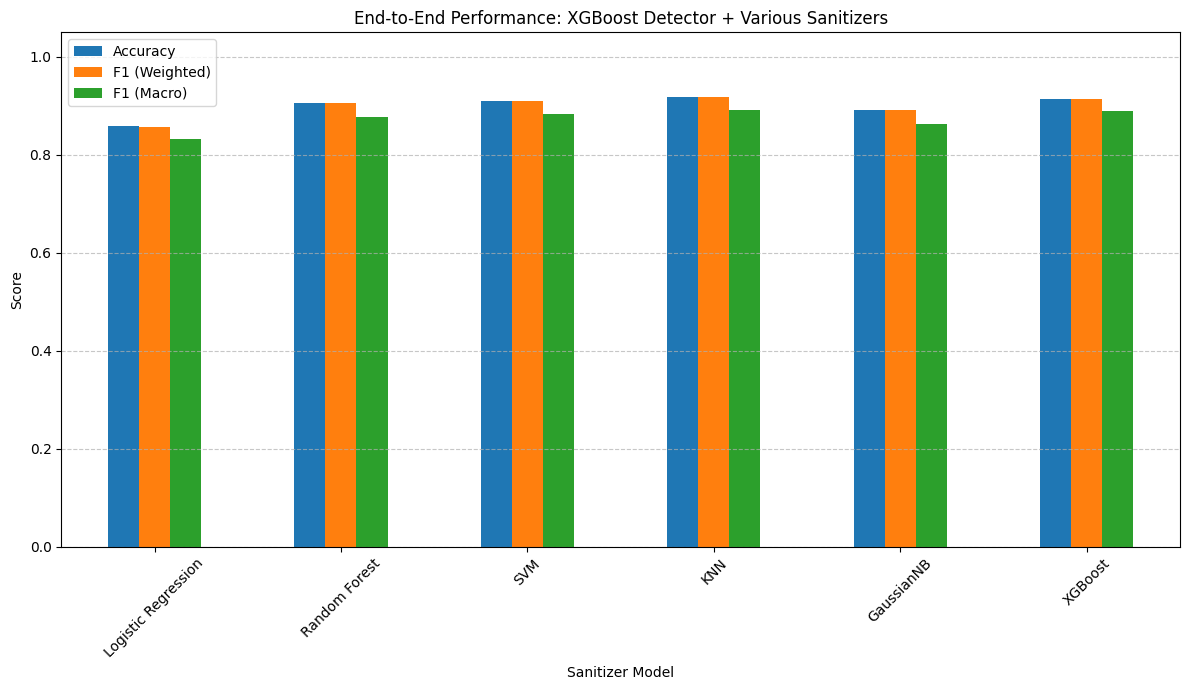


End-to-End Confusion Matrix for Best Combination (XGBoost + KNN):


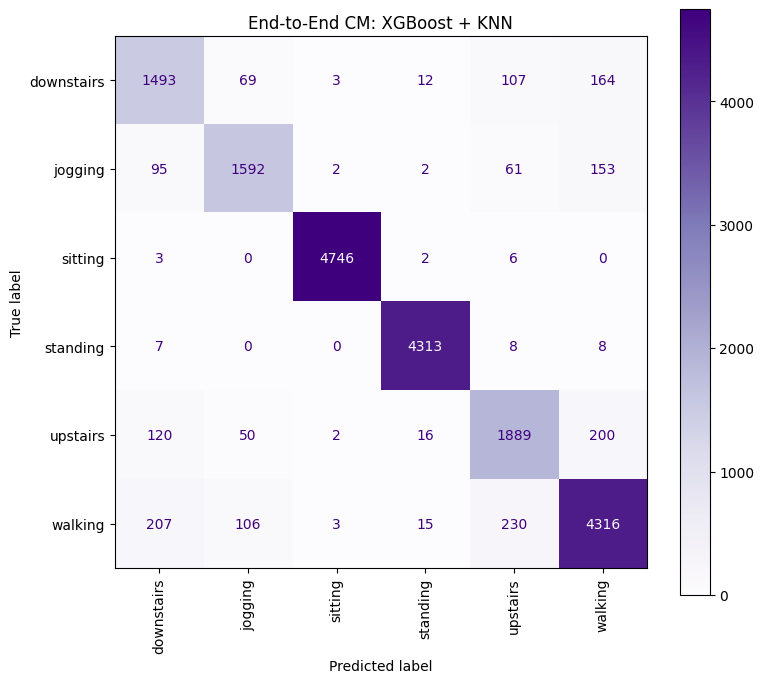

In [21]:
# Cell 11: Evaluate End-to-End Performance (Using Best Detector + Each Sanitizer)

print("\\n" + "="*60)
print("--- Evaluating End-to-End Performance ---")
print("(Using a selected Detector paired with each Sanitizer)")
print("="*60)

# --- Step 1: Select the Best Detector ---
# We need the 'results' dictionary from the detection evaluation (Cell 7&8)
if 'results' not in globals() or not results:
    raise NameError("Detection results ('results' dictionary) not found. Please run Cell 7&8 first.")

# Choose the metric for selecting the best detector (e.g., highest F1 score for the poisoned class)
best_detector_name = None
best_detector_score = -1
detection_metric_to_optimize = 'F1 (Poisoned)' # Or 'Recall (Poisoned)', 'Accuracy', etc.

for name, data in results.items():
    # Check if model ran successfully and has the metric
    if data.get('Training Time (s)', -1) >= 0 and detection_metric_to_optimize in data:
        if data[detection_metric_to_optimize] > best_detector_score:
            best_detector_score = data[detection_metric_to_optimize]
            best_detector_name = name

if best_detector_name is None:
    raise ValueError("Could not determine the best detector model from the results.")

print(f"Selected Best Detector: '{best_detector_name}' (based on highest '{detection_metric_to_optimize}' = {best_detector_score:.4f})")

# Get the predictions made by this best detector on the test set
# These predictions indicate which samples the detector *thinks* are poisoned (1) or clean (0)
detector_predictions = results[best_detector_name].get('Predictions')
if detector_predictions is None:
     raise ValueError(f"Predictions for the best detector '{best_detector_name}' not found in results.")
if len(detector_predictions) != len(test_df):
     raise ValueError(f"Mismatch in length between detector predictions ({len(detector_predictions)}) and test_df ({len(test_df)}).")

# Store these predictions in test_df for clarity (overwriting previous 'detected_poisoned' if it existed)
test_df['detected_poisoned_by_best'] = detector_predictions


# --- Step 2: Evaluate End-to-End for each Sanitizer paired with the Best Detector ---
end_to_end_results = {}
y_true_final = test_df[ORIGINAL_LABEL_COL] # The ground truth original labels

print(f"\nEvaluating End-to-End Performance using Detector '{best_detector_name}':")

for sani_name, sani_data in sanitizer_results.items():
    # Check if sanitizer was trained successfully
    if sani_data.get('Training Time (s)', -1) < 0:
        print(f"- Skipping Sanitizer '{sani_name}' (failed during training/evaluation).")
        continue

    print(f"- Pairing with Sanitizer: '{sani_name}'")

    # Get the sanitized label predictions made by this specific sanitizer
    sanitizer_pred_labels = sani_data.get('Predictions (Labels)')
    if sanitizer_pred_labels is None:
        print(f"  ERROR: Predictions not found for sanitizer '{sani_name}'. Skipping.")
        continue
    if len(sanitizer_pred_labels) != len(test_df):
        print(f"  ERROR: Length mismatch for sanitizer '{sani_name}' predictions. Skipping.")
        continue

    # Determine the Final Label based on the BEST Detector + CURRENT Sanitizer
    # If detector thinks sample is poisoned (1), use this sanitizer's prediction.
    # Otherwise (0), use the originally reported label (which might be clean or poisoned but undetected).
    final_label = np.where(
        test_df['detected_poisoned_by_best'] == 1, # Condition based on best detector's output
        sanitizer_pred_labels,                     # Value if True (use current sanitizer output)
        test_df[REPORTED_LABEL_COL]                # Value if False (use reported label)
    )

    # Store the final label for this combination
    test_df[f'final_label_{best_detector_name}_{sani_name}'] = final_label

    # Evaluate this final label against the true original label
    accuracy_final = accuracy_score(y_true_final, final_label)
    f1_final_weighted = f1_score(y_true_final, final_label, average='weighted', zero_division=0)
    f1_final_macro = f1_score(y_true_final, final_label, average='macro', zero_division=0)
    cm_final = confusion_matrix(y_true_final, final_label, labels=activity_labels)

    # Store results
    end_to_end_results[sani_name] = {
        'Detector Used': best_detector_name,
        'Sanitizer Used': sani_name,
        'Accuracy': accuracy_final,
        'F1 (Weighted)': f1_final_weighted,
        'F1 (Macro)': f1_final_macro,
        'Confusion Matrix': cm_final
        # 'Final Labels': final_label # Optional: store if needed
    }
    print(f"  End-to-End Accuracy: {accuracy_final:.4f}")
    print(f"  End-to-End F1 (Weighted): {f1_final_weighted:.4f}")


# --- Consolidate End-to-End Results ---
end_to_end_results_df = pd.DataFrame.from_dict(end_to_end_results, orient='index')
end_to_end_summary = end_to_end_results_df[['Accuracy', 'F1 (Weighted)', 'F1 (Macro)']].sort_values(by='F1 (Weighted)', ascending=False)

print("\n\n" + "="*60)
print(f"--- End-to-End Performance Summary (Detector: {best_detector_name}) ---")
print("="*60)
print(end_to_end_summary)

# --- Visualizations for End-to-End Comparison ---
print("\n\n" + "="*60)
print(f"--- End-to-End Performance Visualizations (Detector: {best_detector_name}) ---")
print("="*60)

if end_to_end_results_df.empty:
    print("No end-to-end results calculated successfully, skipping visualizations.")
else:
    # --- Bar Chart: Key Metrics ---
    metrics_to_plot_e2e = ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)']
    end_to_end_results_df[metrics_to_plot_e2e].plot(kind='bar', figsize=(12, 7), rot=45)
    plt.title(f'End-to-End Performance: {best_detector_name} Detector + Various Sanitizers')
    plt.ylabel('Score')
    plt.xlabel('Sanitizer Model')
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Confusion Matrix for the Best Overall End-to-End Combination ---
    best_e2e_sanitizer = end_to_end_summary.index[0] if not end_to_end_summary.empty else None
    if best_e2e_sanitizer and end_to_end_results[best_e2e_sanitizer]['Confusion Matrix'] is not None:
        print(f"\nEnd-to-End Confusion Matrix for Best Combination ({best_detector_name} + {best_e2e_sanitizer}):")
        cm_best_e2e = end_to_end_results[best_e2e_sanitizer]['Confusion Matrix']
        fig, ax = plt.subplots(figsize=(8, 7))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_e2e, display_labels=activity_labels)
        disp.plot(ax=ax, cmap='Purples', xticks_rotation='vertical')
        ax.set_title(f'End-to-End CM: {best_detector_name} + {best_e2e_sanitizer}')
        plt.tight_layout()
        plt.show()
    elif best_e2e_sanitizer:
         print(f"Could not plot confusion matrix for best end-to-end combo ({best_e2e_sanitizer}).")

In [ ]:
# Cell 12: Comprehensive Evaluation Report (Updated for Multi-Sanitizer Evaluation)

print("\\n" + "="*60)
print(" Comprehensive Detection & Sanitization Report (Multi-Sanitizer)")
print("="*60)

# --- 1. Dataset Information ---
print("\\n--- 1. Dataset Configuration ---")
try:
    print(f"Total Samples Processed : {TOTAL_SAMPLES}")
    print(f"Training Set Size       : {TRAIN_SIZE} ({len(train_df)} actual)")
    print(f"Test Set Size           : {TEST_SIZE} ({len(test_df)} actual)")
    train_poison_rate = train_df[POISON_FLAG_COL].mean()
    test_poison_rate = test_df[POISON_FLAG_COL].mean()
    print(f"Poisoning Rate (Train)  : {train_poison_rate:.3f}")
    print(f"Poisoning Rate (Test)   : {test_poison_rate:.3f}")
    print(f"Activity Labels         : {activity_labels}")
except NameError as e:
    print(f"Error accessing dataset info variables: {e}. Ensure Cells 2-5 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing dataset info: {e}")


# --- 2. Detection Model Performance Summary ---
print("\\n--- 2. Poisoning Detection Models Performance ---")
try:
    if 'results_summary' in globals():
         print("Summary on Test Set (Sorted by F1 Score for Poisoned Class):")
         print(results_summary)
         print("\\nNote: Recall and F1 scores shown are for the 'Poisoned (1)' class.")
    else:
         print("Detection results summary not available. Ensure Cell 7&8 ran successfully.")
    # Identify the detector used for end-to-end evaluation
    if 'best_detector_name' in globals():
        print(f"\nDetector selected for End-to-End Evaluation: '{best_detector_name}'")
    else:
        print("\nDetector for End-to-End Evaluation not identified.")
except NameError as e:
    print(f"Error accessing detection model variables: {e}. Ensure Cell 7&8 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing detection results: {e}")


# --- 3. Sanitization Model Performance Summary (Direct Evaluation) ---
print("\\n--- 3. Label Sanitization Models Performance (Direct Evaluation) ---")
print("(Evaluated on predicting the true original label from sensor data)")
try:
    if 'sanitizer_summary' in globals():
        print("Summary on Test Set (Sorted by Weighted F1 Score):")
        print(sanitizer_summary)
    else:
        print("Sanitizer results summary not available. Ensure Cell 10 ran successfully.")
except NameError as e:
    print(f"Error accessing sanitization model variables: {e}. Ensure Cell 10 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing sanitization results: {e}")


# --- 4. End-to-End System Performance Summary ---
print(f"\\n--- 4. End-to-End System Performance (Using Detector: {best_detector_name or 'N/A'}) ---")
print("(Final label uses sanitizer prediction if detector flagged sample, else uses reported label)")
try:
    if 'end_to_end_summary' in globals():
        print("Summary on Test Set (Sorted by Weighted F1 Score):")
        print(end_to_end_summary)
        # Optionally print the best combination's detailed report
        if best_e2e_sanitizer and best_detector_name:
             print(f"\nDetailed Report for Best Combination ({best_detector_name} + {best_e2e_sanitizer}):")
             best_combo_data = end_to_end_results.get(best_e2e_sanitizer)
             if best_combo_data:
                 print(f"  Accuracy      : {best_combo_data['Accuracy']:.4f}")
                 print(f"  F1 (Weighted) : {best_combo_data['F1 (Weighted)']:.4f}")
                 print(f"  F1 (Macro)    : {best_combo_data['F1 (Macro)']:.4f}")
                 # print("  Confusion Matrix:\n", best_combo_data['Confusion Matrix']) # Can be large
                 print("\n  Classification Report (End-to-End):")
                 # Need to generate the report using stored final labels
                 final_labels_best_combo = test_df.get(f'final_label_{best_detector_name}_{best_e2e_sanitizer}')
                 if final_labels_best_combo is not None:
                      print(classification_report(y_true_final, final_labels_best_combo, labels=activity_labels, target_names=activity_labels, zero_division=0))
                 else:
                      print("  Could not generate classification report (final labels not found).")

             else:
                  print("  Could not retrieve data for the best combination.")

    else:
        print("End-to-end results summary not available. Ensure Cell 11 ran successfully.")

except NameError as e:
    print(f"Error accessing end-to-end variables: {e}. Ensure Cell 11 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing end-to-end results: {e}")

print("\\n" + "="*60)
print(" End of Report")
print("="*60)

\n============================================================
 Comprehensive Detection & Sanitization Report (Multi-Sanitizer)
\n--- 1. Dataset Configuration ---
Total Samples Processed : 120000
Training Set Size       : 100000 (100000 actual)
Test Set Size           : 20000 (20000 actual)
Poisoning Rate (Train)  : 0.250
Poisoning Rate (Test)   : 0.250
Activity Labels         : ['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']
\n--- 2. Poisoning Detection Models Performance ---
Summary on Test Set (Sorted by F1 Score for Poisoned Class):
                     Training Time (s)  Accuracy  Recall (Poisoned)  \
XGBoost                       0.560768   0.93005           0.770168   
Random Forest                 4.966654   0.91745           0.680112   
KNN                           0.006605   0.91015           0.709864   
SVM                        6068.137391   0.90145           0.643171   
GaussianNB                    0.029016   0.66190           0.545927   
Logisti